# Music-Learning

# Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in `1`.

In [13]:
'''
Imports
'''
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
from sklearn.metrics import precision_score, accuracy_score, auc, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import tensorflow as ft
from tensorflow import keras
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier

import ast
import os

# Data loading and preprocessing

First thing, we load the dataset

In [14]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [15]:
'''
Constants and file paths
'''
path = "dataset/fma_metadata/"
tracks_file = "tracks.csv"
genres_file = "genres.csv"
echonest_file = "echonest.csv"
features_file = "features.csv"

In [16]:
# src: fma dataset and code
ds_tracks = load(path+tracks_file)
ds_genres = load(path+genres_file)
ds_features = load(path+features_file)
ds_echonest = load(path+echonest_file)

((2000, 2), (2000,))

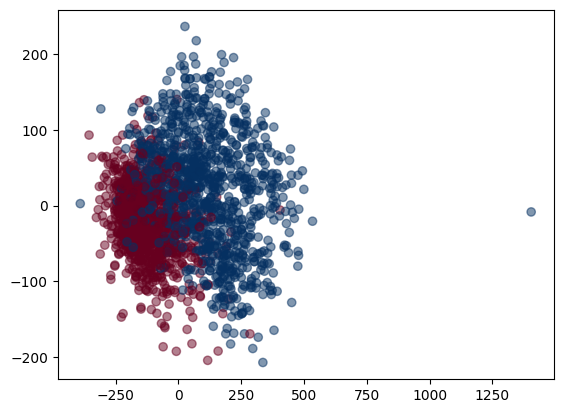

In [17]:
small = ds_tracks['set', 'subset'] <= 'small' # extract the dataset for 'small' set of tracks
genre1 = ds_tracks['track', 'genre_top'] == 'Instrumental'
genre2 = ds_tracks['track', 'genre_top'] == 'Hip-Hop'

X = ds_features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = ds_tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [18]:
# We extract the feature dataset and label dataset from the whole dataset
# The 'mfcc' subset choice comes from the paper.
medium = ds_tracks['set', 'subset'] <= 'medium'
X = ds_features.loc[medium, 'mfcc']
y = ds_tracks.loc[medium, ('track', 'genre_top')]

# then, we extract all the labels that will be used later for data visualization
labels = y.unique()

# extract train, validation and test set form the dataset
train = ds_tracks['set', 'split'] == 'training'
val = ds_tracks['set', 'split'] == 'validation'
test = ds_tracks['set', 'split'] == 'test'

# Extract features and labels for each of the 3 sets
y_train = ds_tracks.loc[medium & train, ('track', 'genre_top')]
y_validate = ds_tracks.loc[medium & val, ('track', 'genre_top')]
y_test = ds_tracks.loc[medium & test, ('track', 'genre_top')]

X_train = ds_features.loc[medium & train , 'mfcc']
X_validate = ds_features.loc[medium & val , 'mfcc']
X_test = ds_features.loc[medium & test , 'mfcc']

print('{} training examples, {} validation examples, {} testing examples'.format(y_train.size,
                                                                                 y_validate.size, 
                                                                                 y_test.size))

19922 training examples, 2505 validation examples, 2573 testing examples


# Classification 
We propose the use of 4 types of different classifiers:
- SVM
- kNN
- logistic regression
- CNN

## SVM
The first classifier used is Support Vector Machines (SVM)

TODO: due parole su svm

In [19]:
'''
Classification using svm
'''
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .70)

# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)
X_validate, y_validate = skl.utils.shuffle(X_validate, y_validate, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
#kernels = ['linear', 'sigmoid', 'rbf', 'poly'] # got by https://dataaspirant.com/svm-kernels/
#for kernel in kernels:
svm_clf = skl.svm.SVC(kernel='rbf', C=1)
#svm_clf = skl.svm.LinearSVC()
val_scores = cross_val_score(svm_clf, X_validate, y_validate, cv=10)
print(val_scores)

svm_clf.fit(X_train, y_train)
svm_preds = svm_clf.predict(X_test)
score = svm_clf.score(X_test, y_test)

print("SVM classification completed")
print(score)

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.57370518 0.55378486 0.54183267 0.57768924 0.56573705 0.572
 0.604      0.58       0.592      0.532     ]
SVM classification completed
0.6097940147687524


## k-Nearest-Neighbours
Next, we use the k Nearest Neighbors classifier (kNN)

TODO: due parole su knn

In [20]:
'''
Classification using kNN
'''

n_neighbors = [10, 20, 30, 40, 50, 60, 100, 200] # the choice is 30

for n_neighb in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighb) # number got by the paper
    
    knn.fit(X_train, y_train)
    
    # cross_validate
    cv_scores = cross_val_score(knn, X_validate, y_validate, cv=10)
    print(cv_scores)
    
    knn_predictions = knn.predict(X_test)

    accuracy_score = knn.score(X_test, y_test) 
    print("Accuracy score = ""{:.2f}".format(accuracy_score))

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.6374502  0.65338645 0.60956175 0.67330677 0.64143426 0.652
 0.66       0.636      0.672      0.648     ]
Accuracy score = 0.56


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.64541833 0.63346614 0.60956175 0.65737052 0.62549801 0.624
 0.64       0.612      0.644      0.632     ]
Accuracy score = 0.57


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.64541833 0.62948207 0.58565737 0.64541833 0.61752988 0.612
 0.632      0.592      0.64       0.636     ]
Accuracy score = 0.57


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.6374502  0.62549801 0.56972112 0.64940239 0.62948207 0.604
 0.608      0.604      0.632      0.612     ]
Accuracy score = 0.57


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.62151394 0.60159363 0.55378486 0.62948207 0.60557769 0.612
 0.584      0.588      0.6        0.596     ]
Accuracy score = 0.57


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.61354582 0.59760956 0.56573705 0.60557769 0.58565737 0.596
 0.588      0.576      0.6        0.588     ]
Accuracy score = 0.57


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.60557769 0.57768924 0.5498008  0.59760956 0.56573705 0.612
 0.576      0.576      0.584      0.552     ]
Accuracy score = 0.56


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[0.55378486 0.54183267 0.54183267 0.56175299 0.51792829 0.568
 0.568      0.552      0.576      0.536     ]
Accuracy score = 0.55


## Logistic regression
As 3rd classifier, we show Logistic regression, with $L^2$ loss function

TODO: due parole su logistic regression e sulla loss scelta.

In [21]:
convertor = skl.preprocessing.LabelEncoder()
#y_train_conv = convertor.fit_transform(y_train)
#y_test_conv = convertor.fit_transform(y_test)
#y_validate_conv = convertor.fit_transform(y_validate)

fit = skl.preprocessing.StandardScaler()
X_train_fit = fit.fit_transform(np.array(X_train, dtype=float))
X_test_fit = fit.fit_transform(np.array(X_test, dtype=float))
X_validate_fit = fit.fit_transform(np.array(X_validate, dtype=float))

# lower the C, the few features will be considered
lr_class = LogisticRegression(C=0.05, penalty="l2", dual=False).fit(X_train_fit, y_train)
#model = SelectFromModel(lr_class, prefit=True)
#X_train_new = model.transform(X_train_fit)

lrcv_scores = cross_val_score(lr_class, X_validate_fit, y_validate, cv=10)
print(cv_scores)

#predictions = lr_class.predict_proba(X_test_fit)
lr_preds = lr_class.predict(X_test_fit)
#print(preds)

#print(lr_class.score(X_test_fit, y_test))
#print(predictions)
print("Linear regression completed")

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

[0.55378486 0.54183267 0.54183267 0.56175299 0.51792829 0.568
 0.568      0.552      0.576      0.536     ]
Linear regression completed


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Multi-layer perceptron

In [22]:
'''
convertor = skl.preprocessing.LabelEncoder()
y_train = convertor.fit_transform(y_train)
y_test = convertor.fit_transform(y_test)
y_validate = convertor.fit_transform(y_validate)


#print(np.unique(y_train_conv).size)
#print(np.unique(y_test_conv).size)

#print(X_train.columns)

#X_train = X_train.drop['track_id']
fit = skl.preprocessing.StandardScaler()
X_train = fit.fit_transform(np.array(X_train, dtype=float))
X_test = fit.fit_transform(np.array(X_test, dtype=float))
X_validate = fit.fit_transform(np.array(X_validate, dtype=float))
'''
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150,), random_state=1)
mlp_clf.fit(X_train, y_train)
mlp_predictions = mlp_clf.predict(X_test)

#score = mlp_clf.score(X_test, y_test)
#print(score)
print("MLP completed")

MLP completed


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Classifiers metrics and comparison
Last, we evaluate performance metrics for the different classifiers and compare the
results obtained.

We compute 4 different metrics for each classifier:

| Metric | Expression|
|:-------- | :-------------------------------------------------: |
| Accuracy | $\tfrac{TN + TP}{TP+FP+TN+FN}$ |
| Precision | $\tfrac{TP}{TP + FP}$ |
| Recall | $\tfrac{TP}{TP + FN}$ |
| F1-score | $2 \cdot \tfrac{Precision \cdot Recal}{Precision + Recal}$ |

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
N.B: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balance.

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defin

---------------------------------------------------------------------------------------

SVM results:


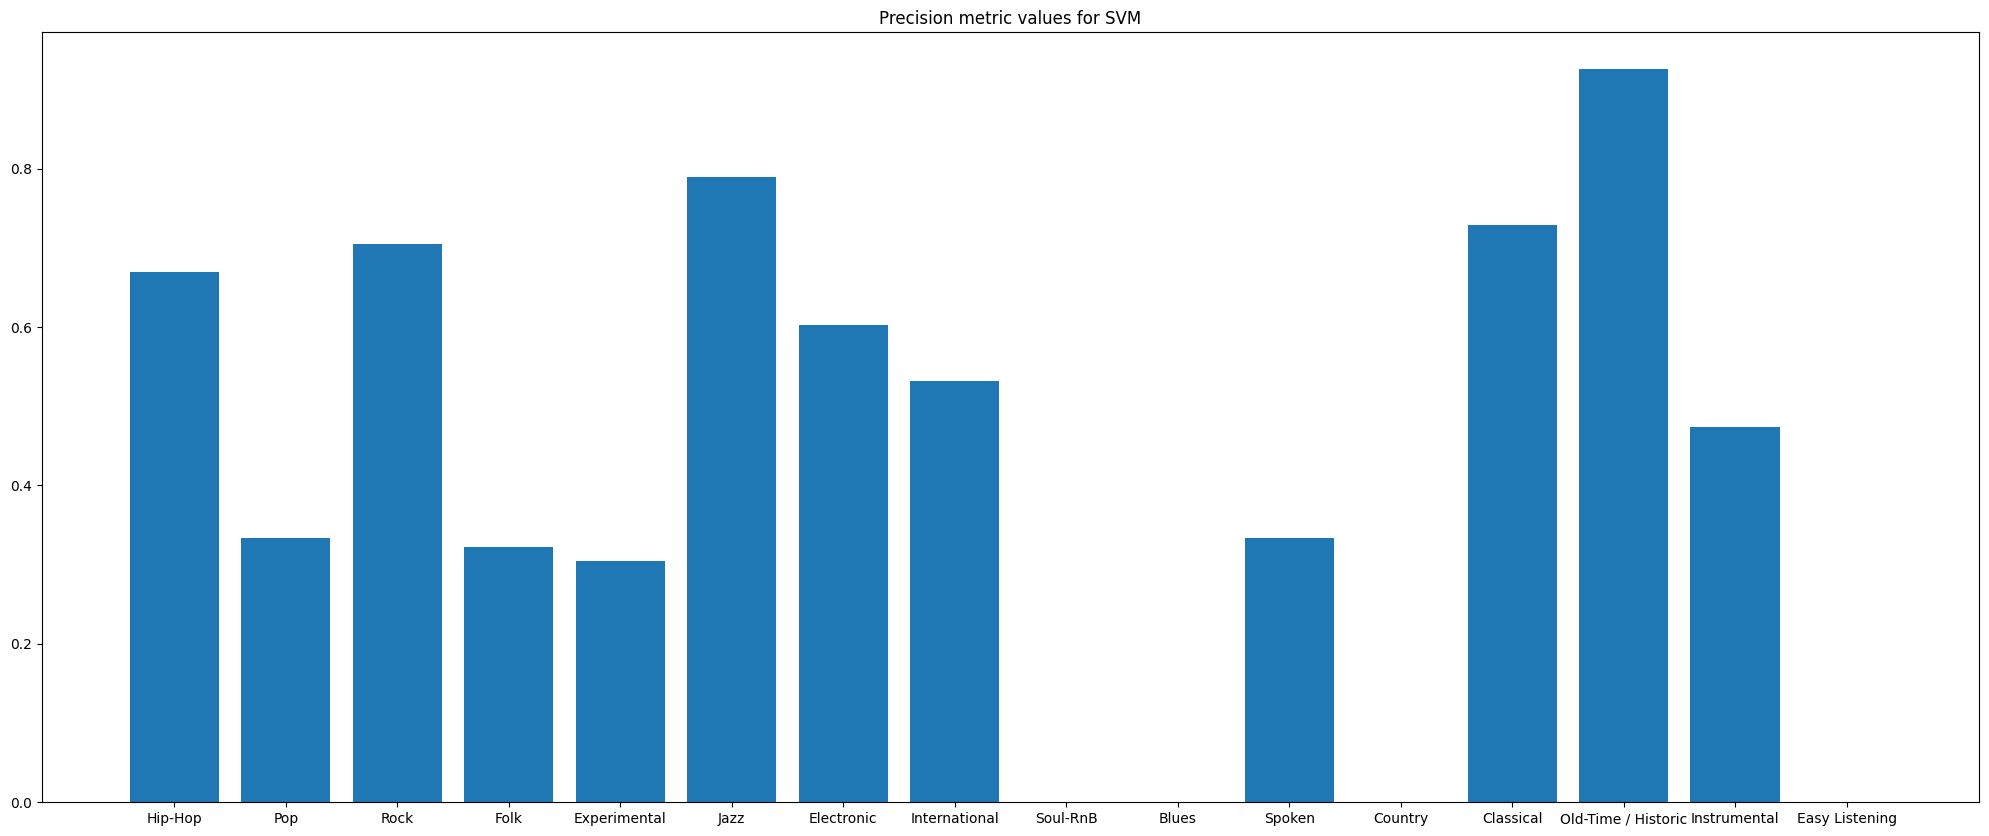

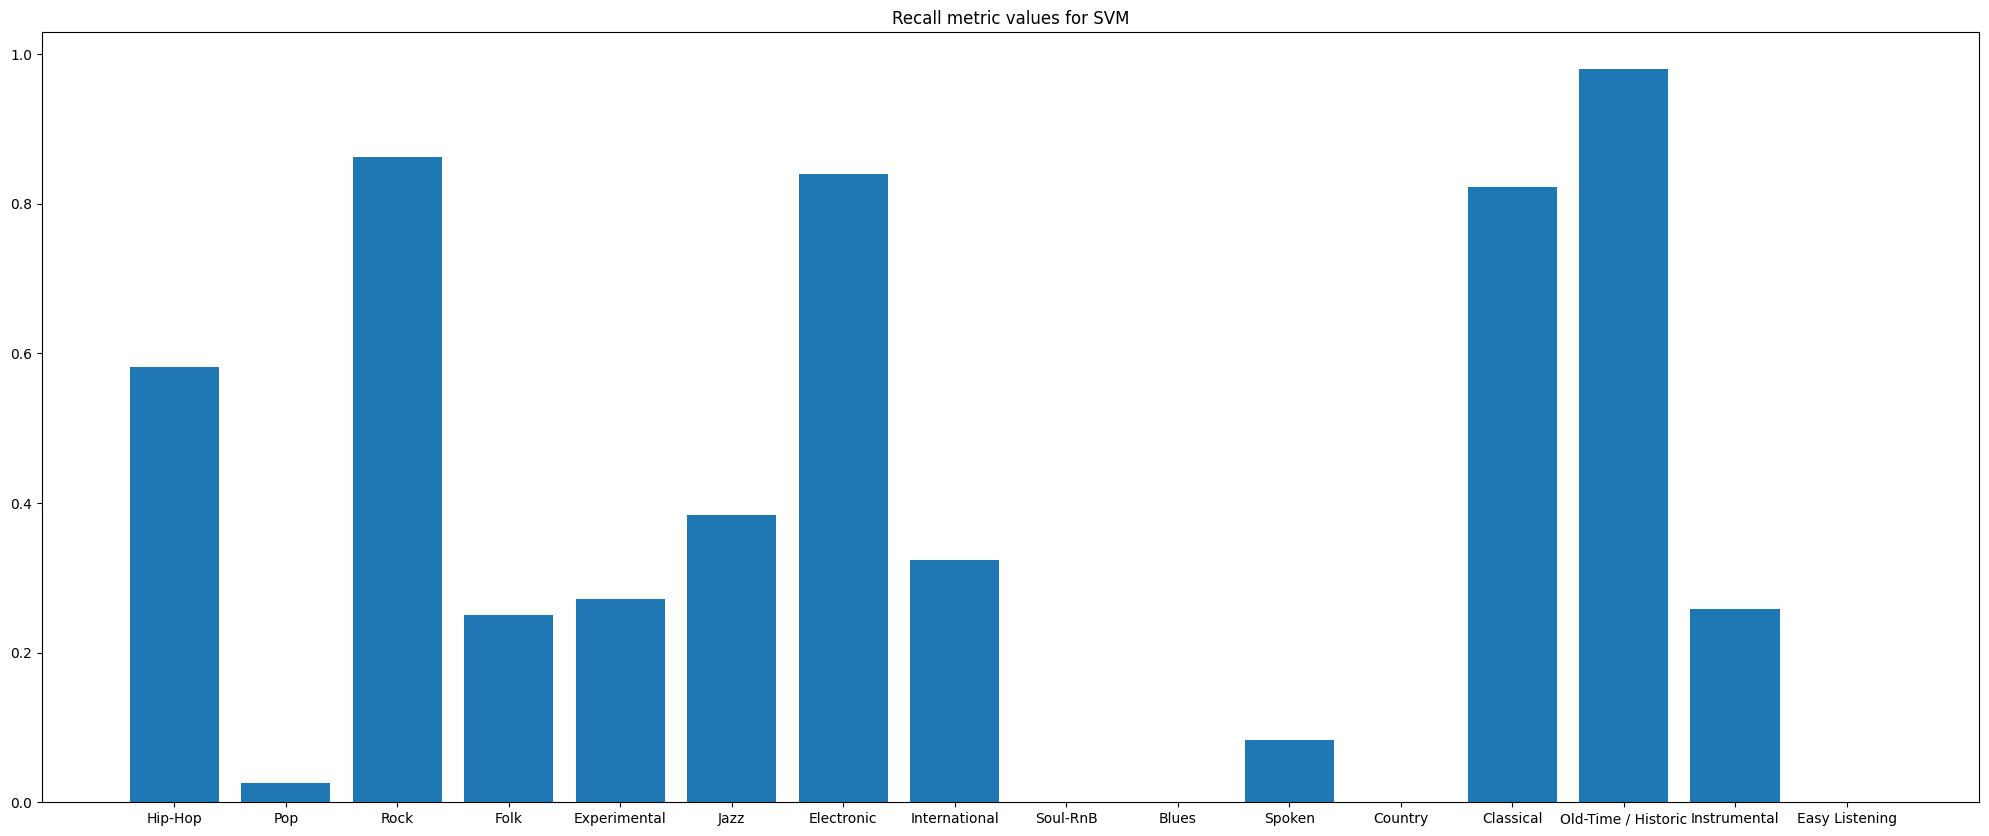

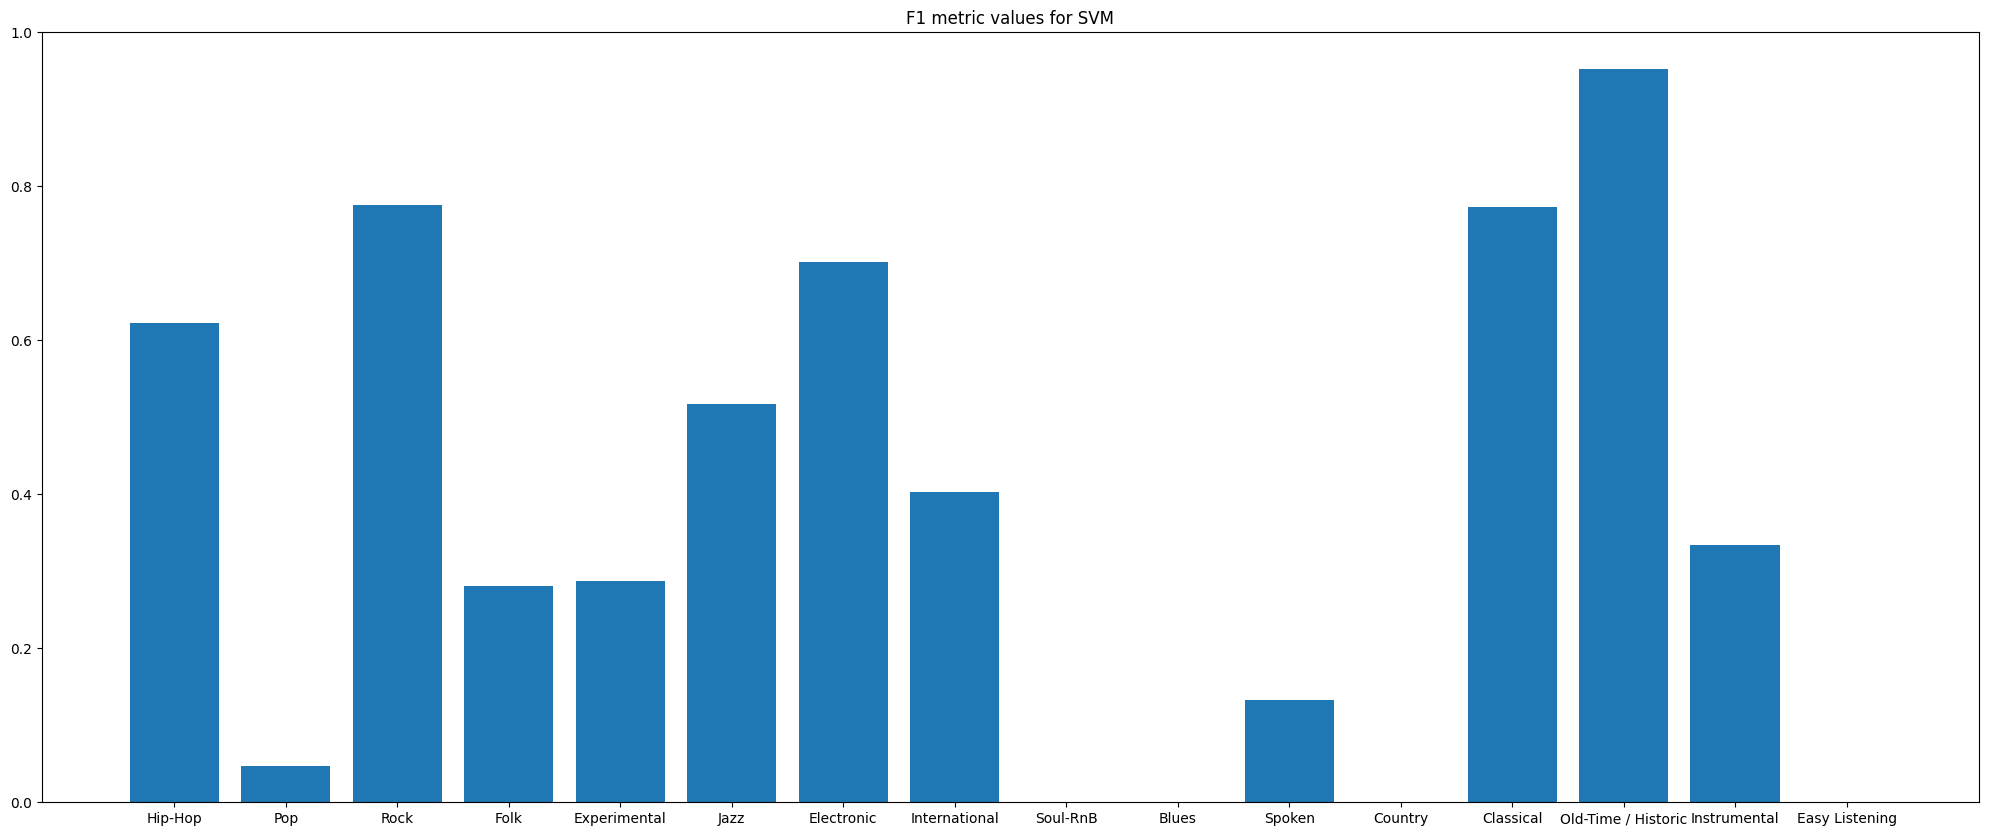

---------------------------------------------------------------------------------------

kNN results: 


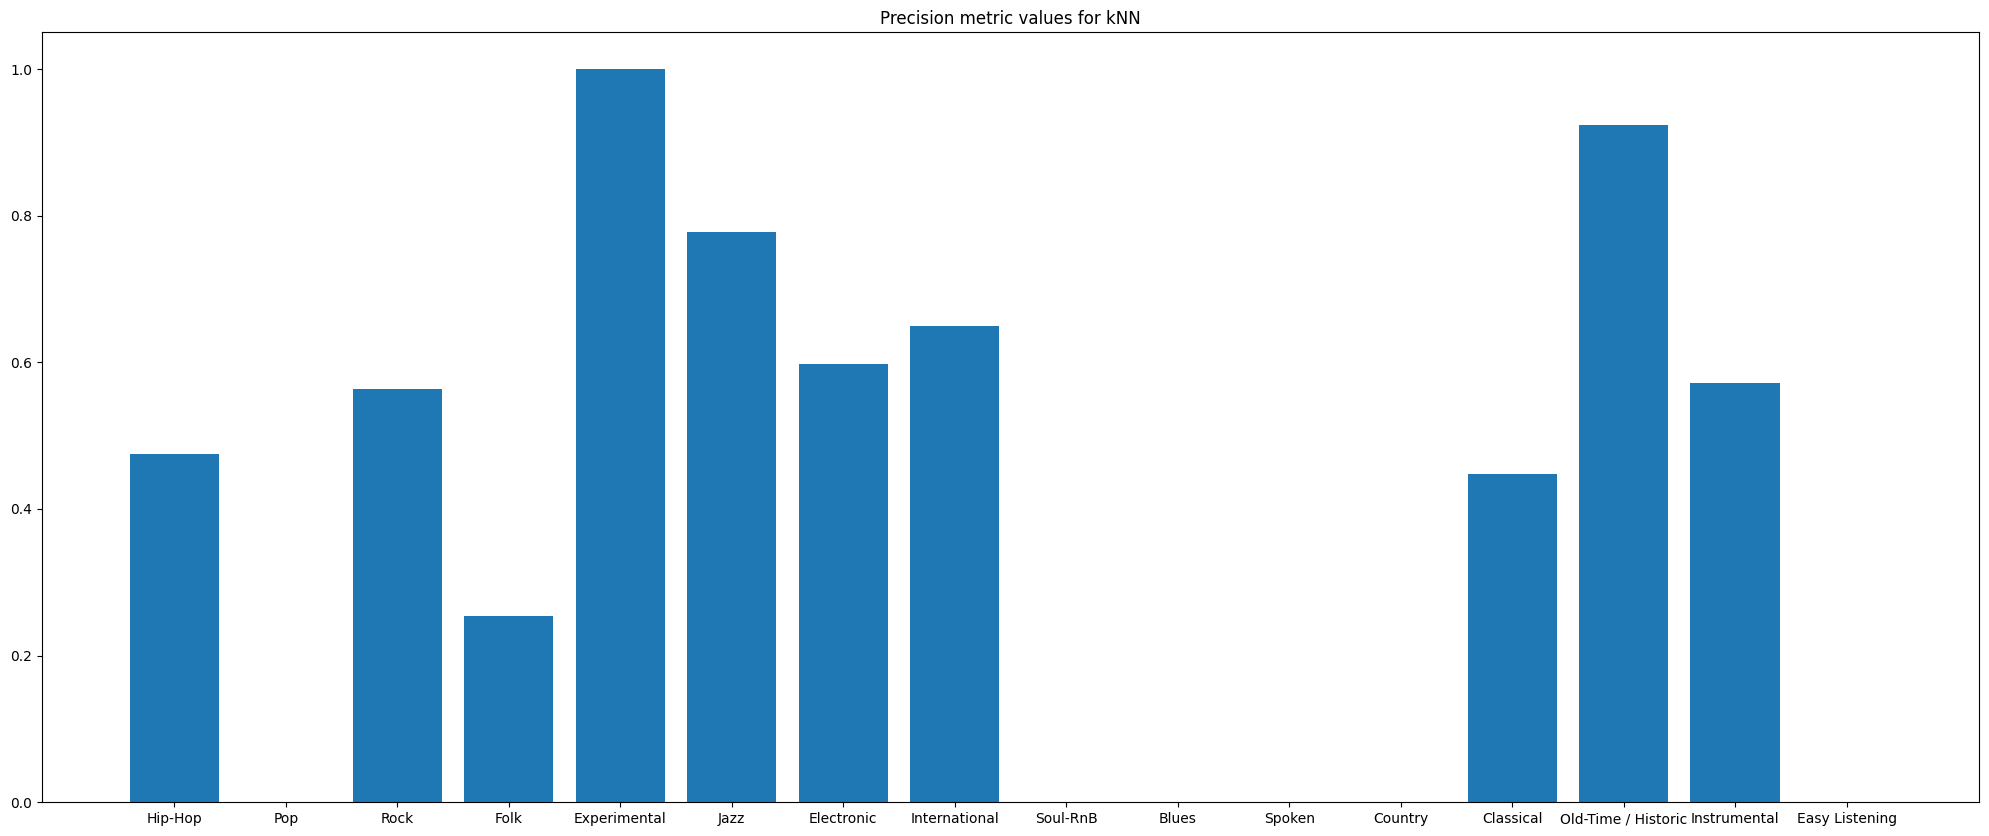

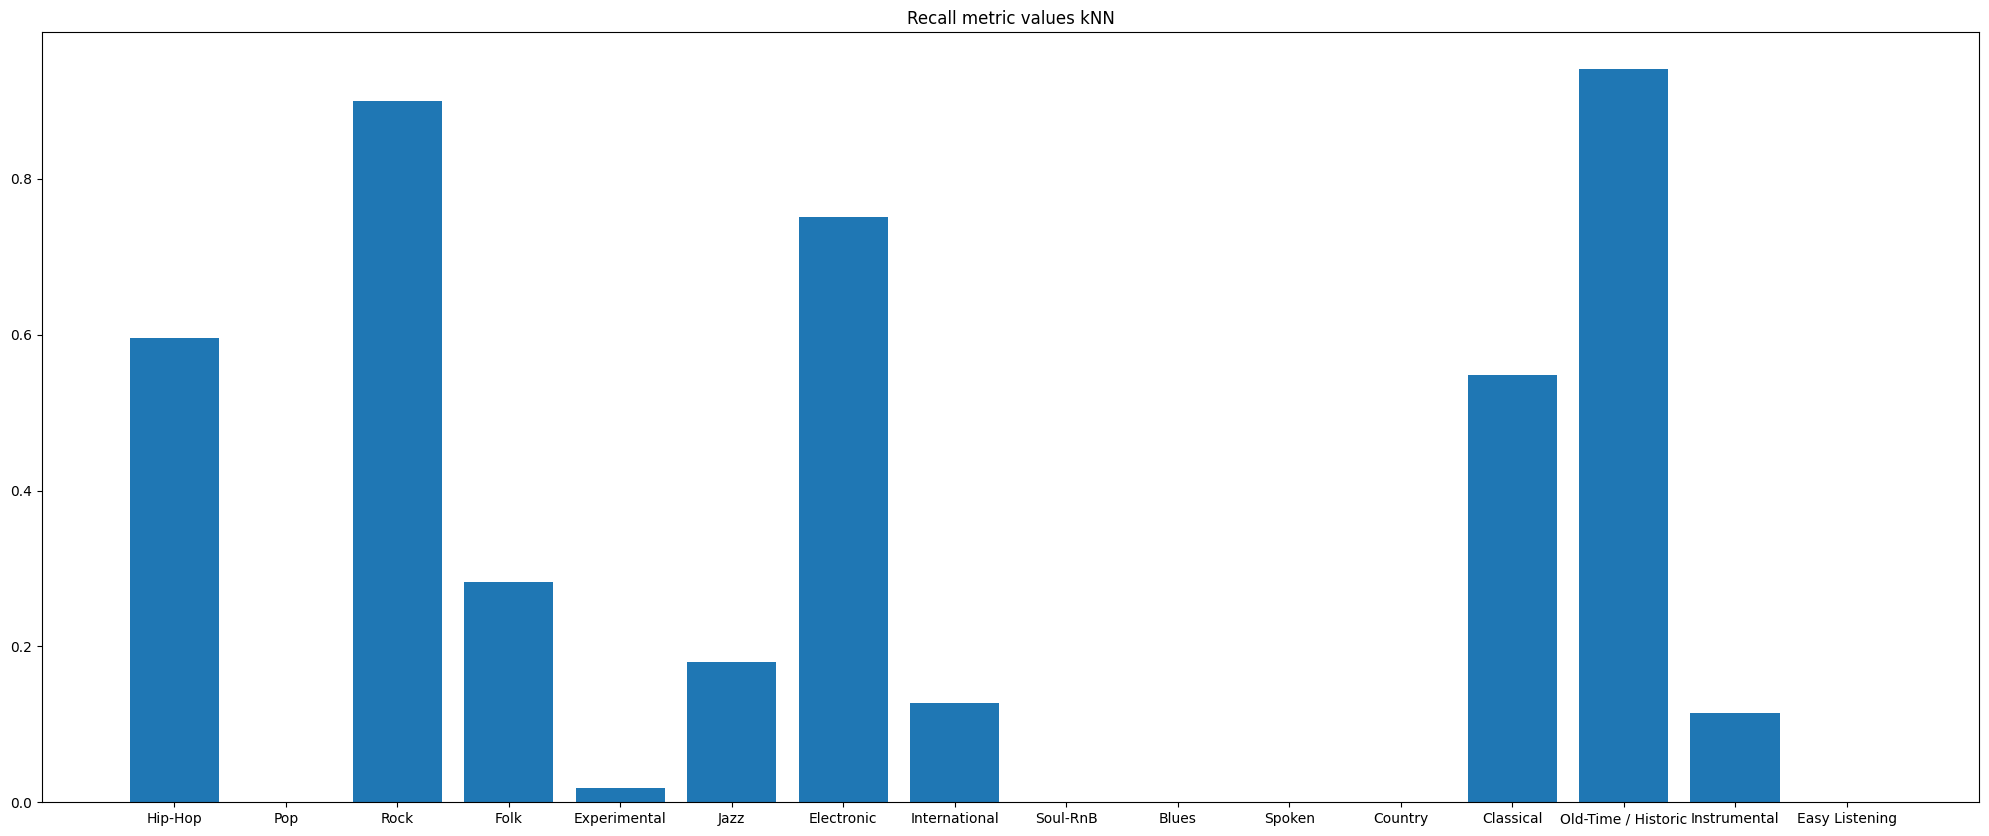

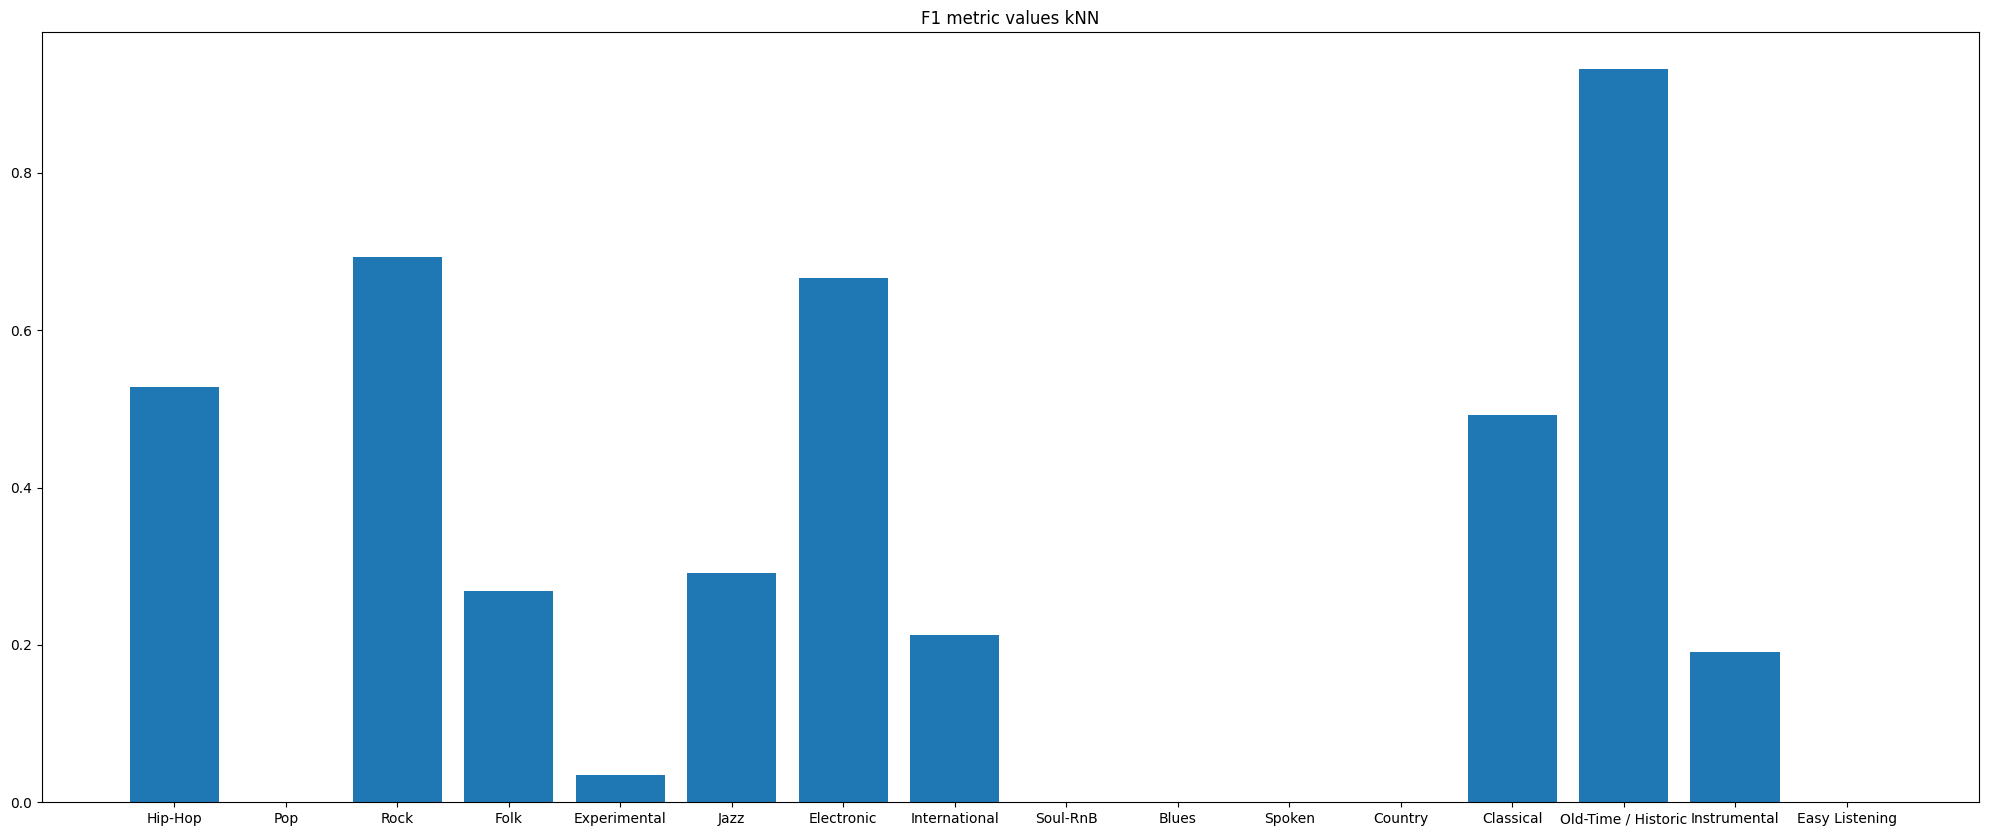

---------------------------------------------------------------------------------------

Linear Regression results: 


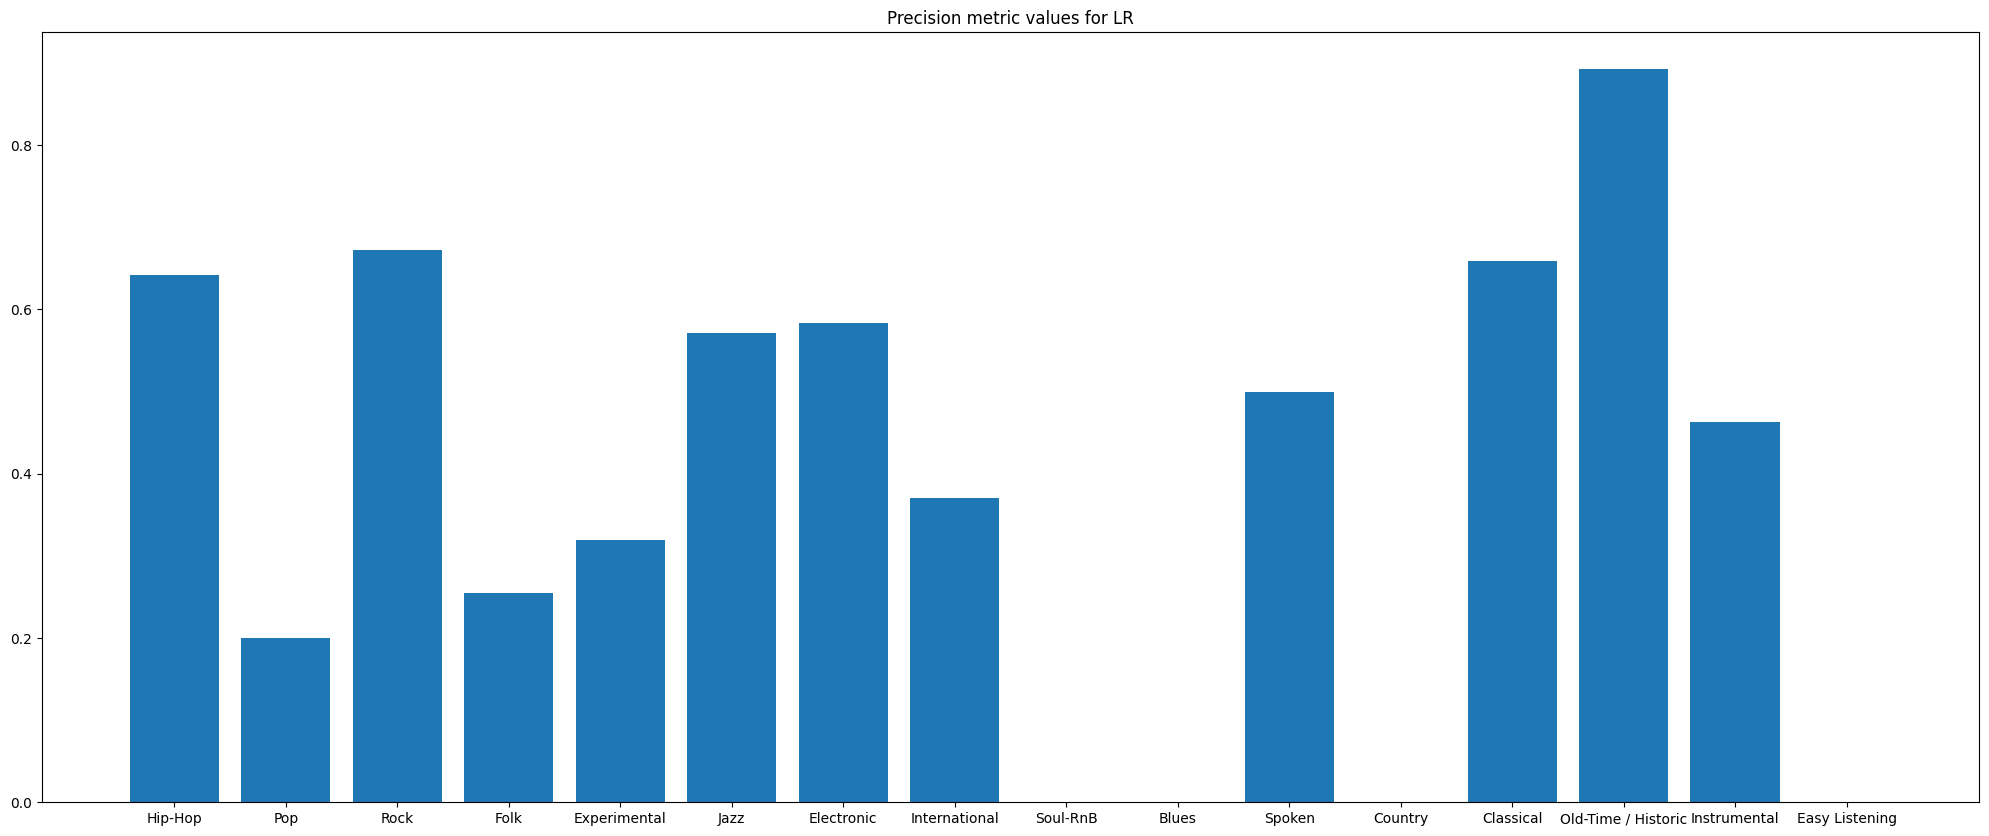

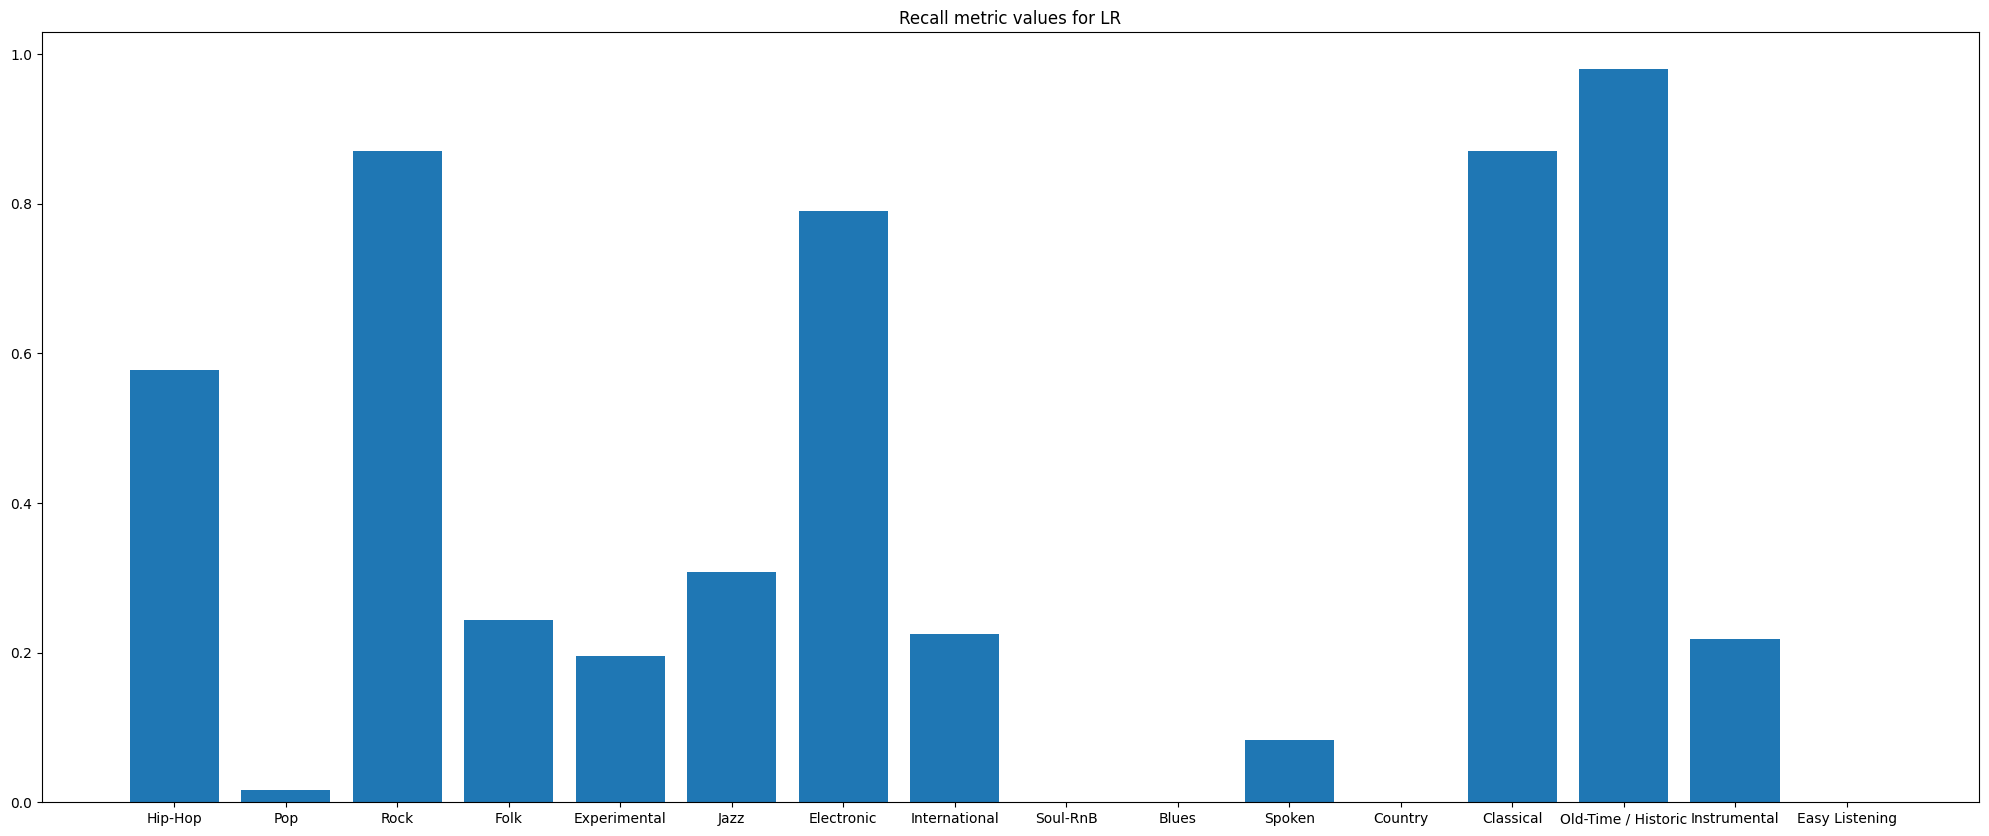

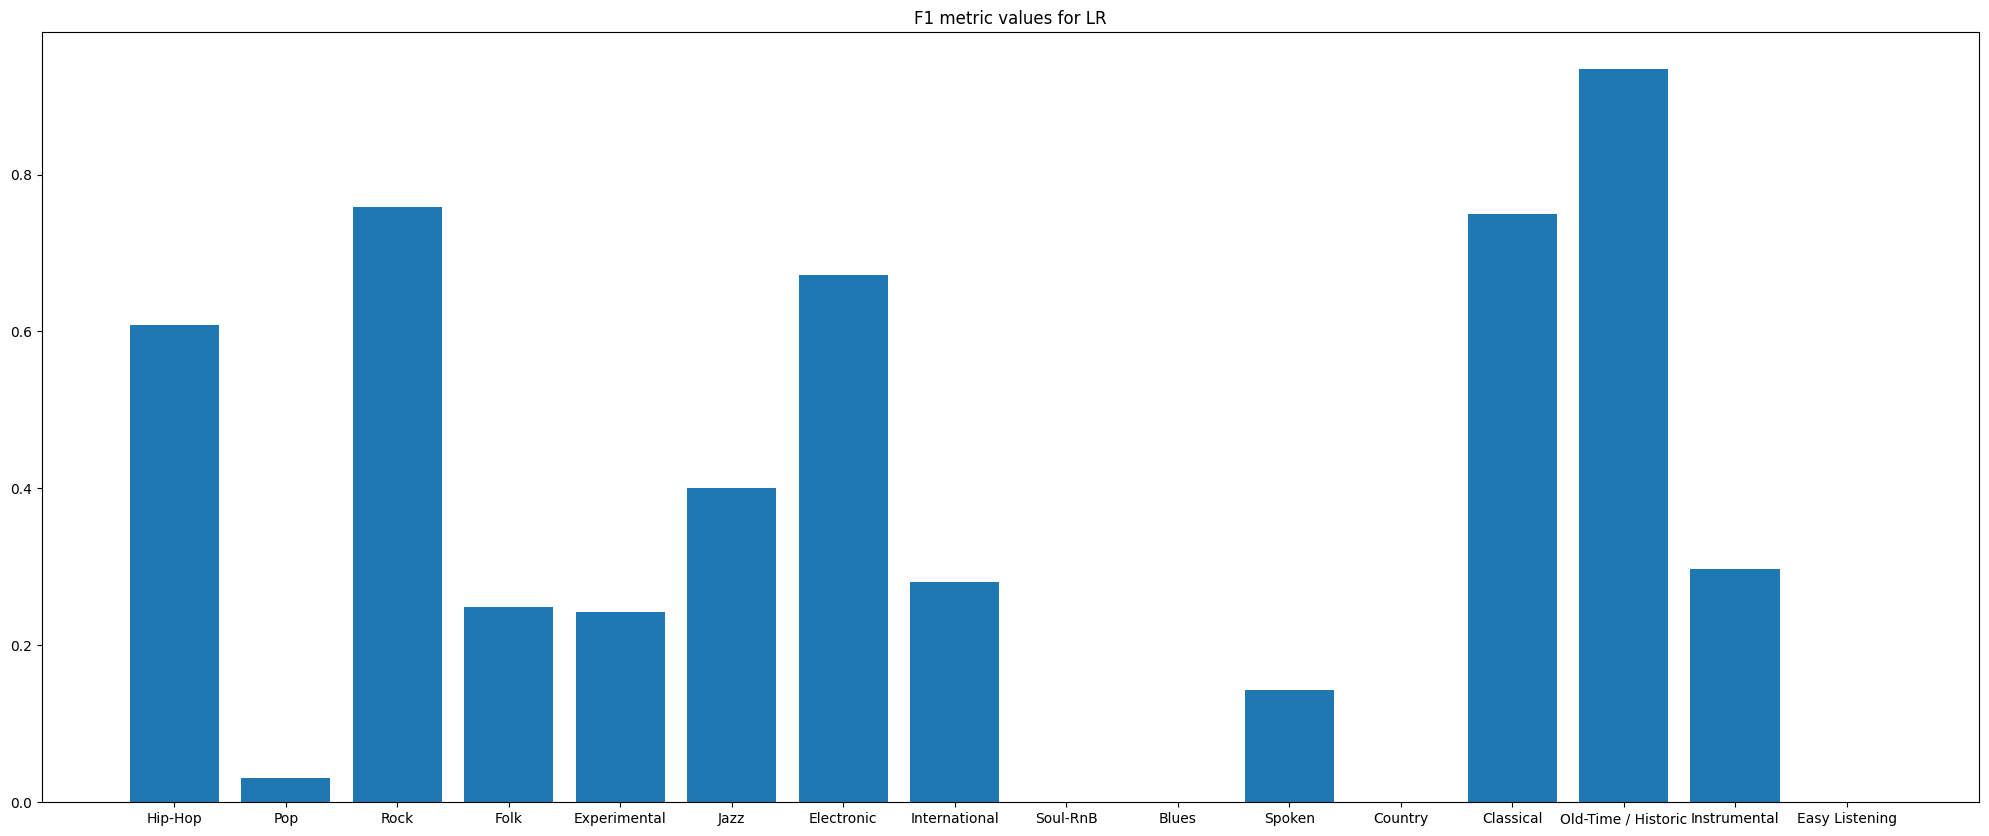

---------------------------------------------------------------------------------------

Multi Layer Perceptron results: 


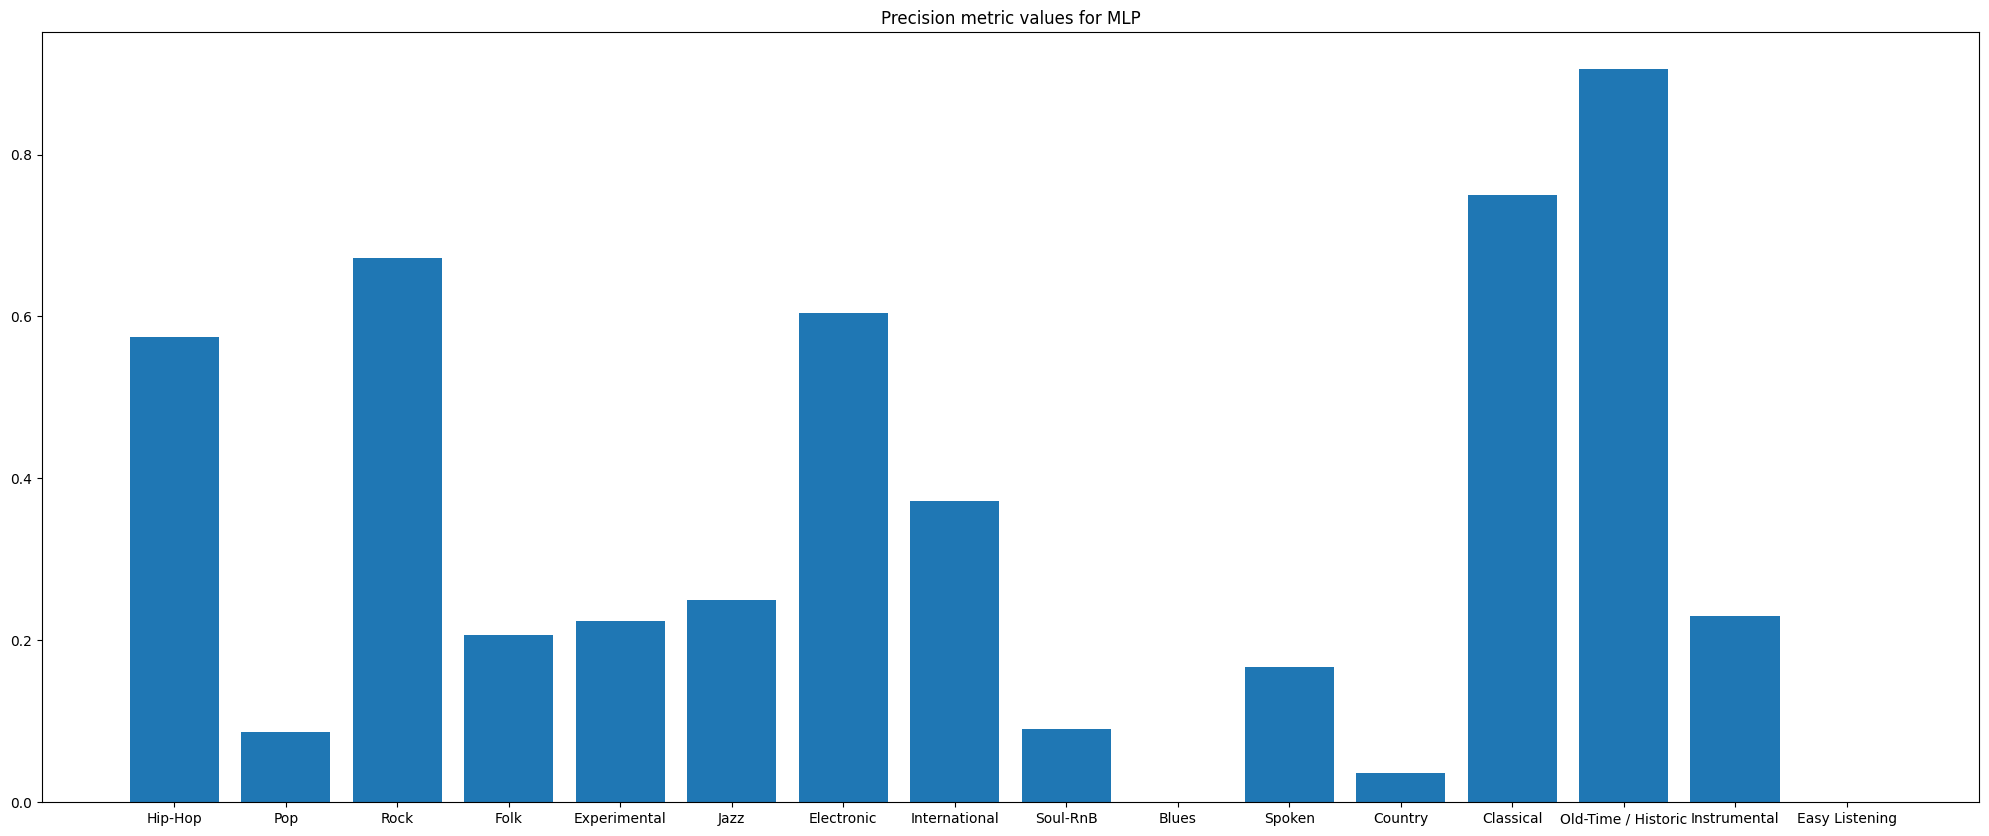

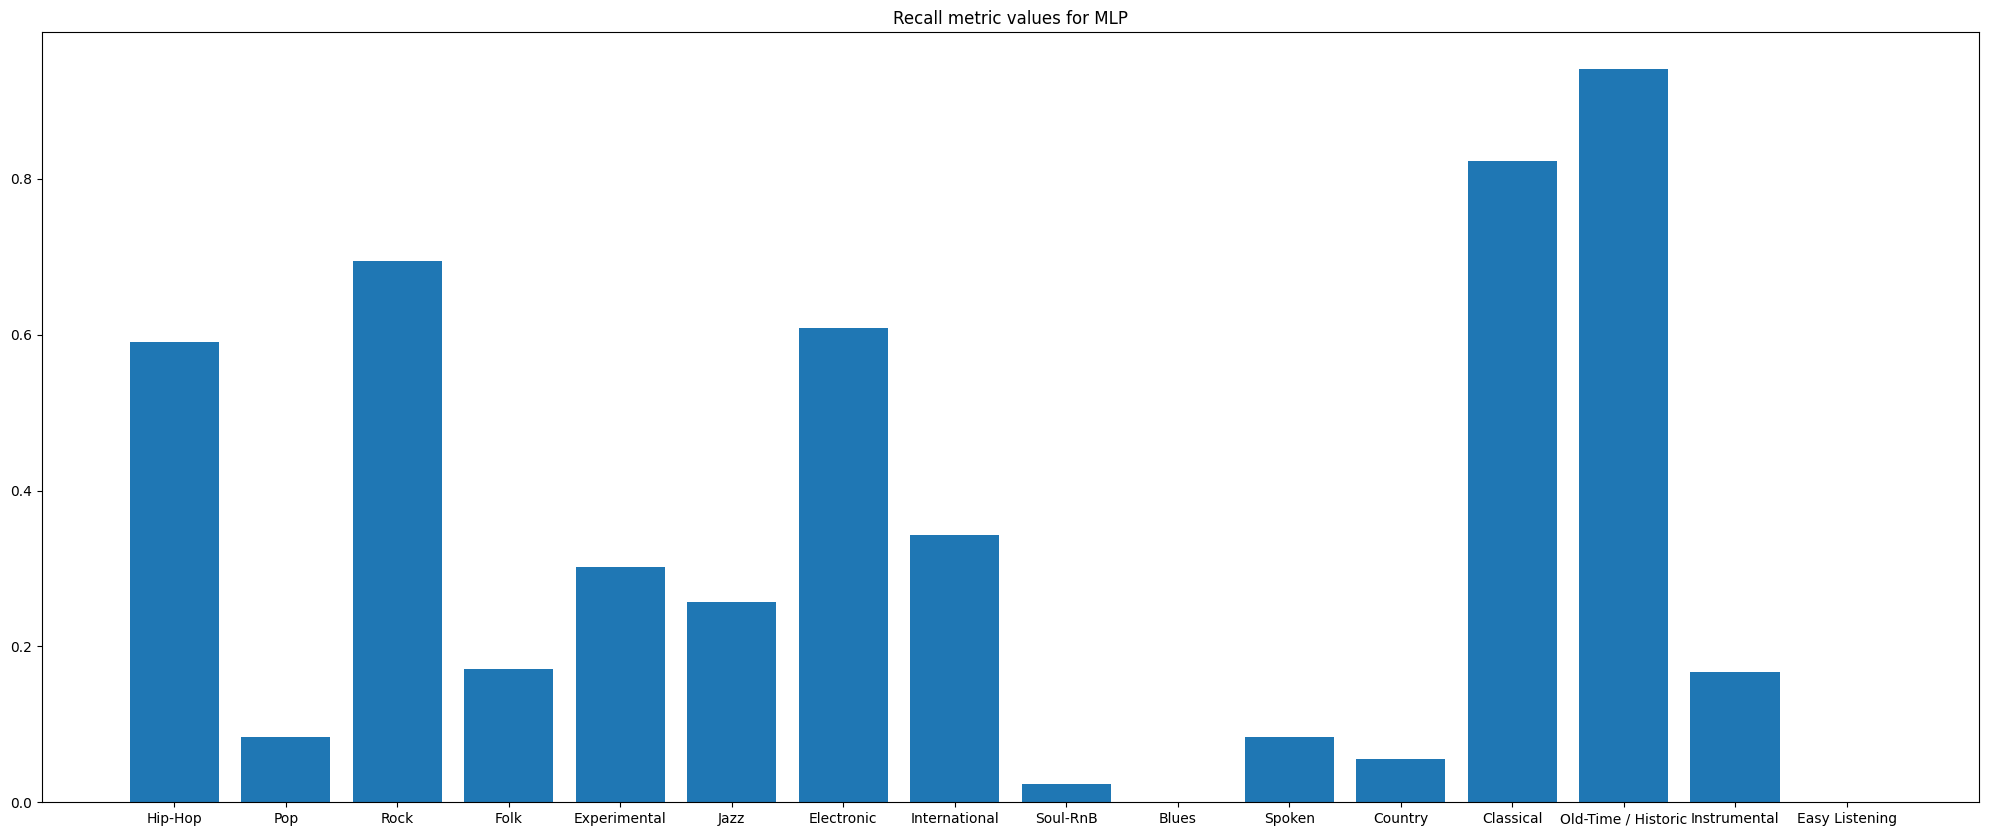

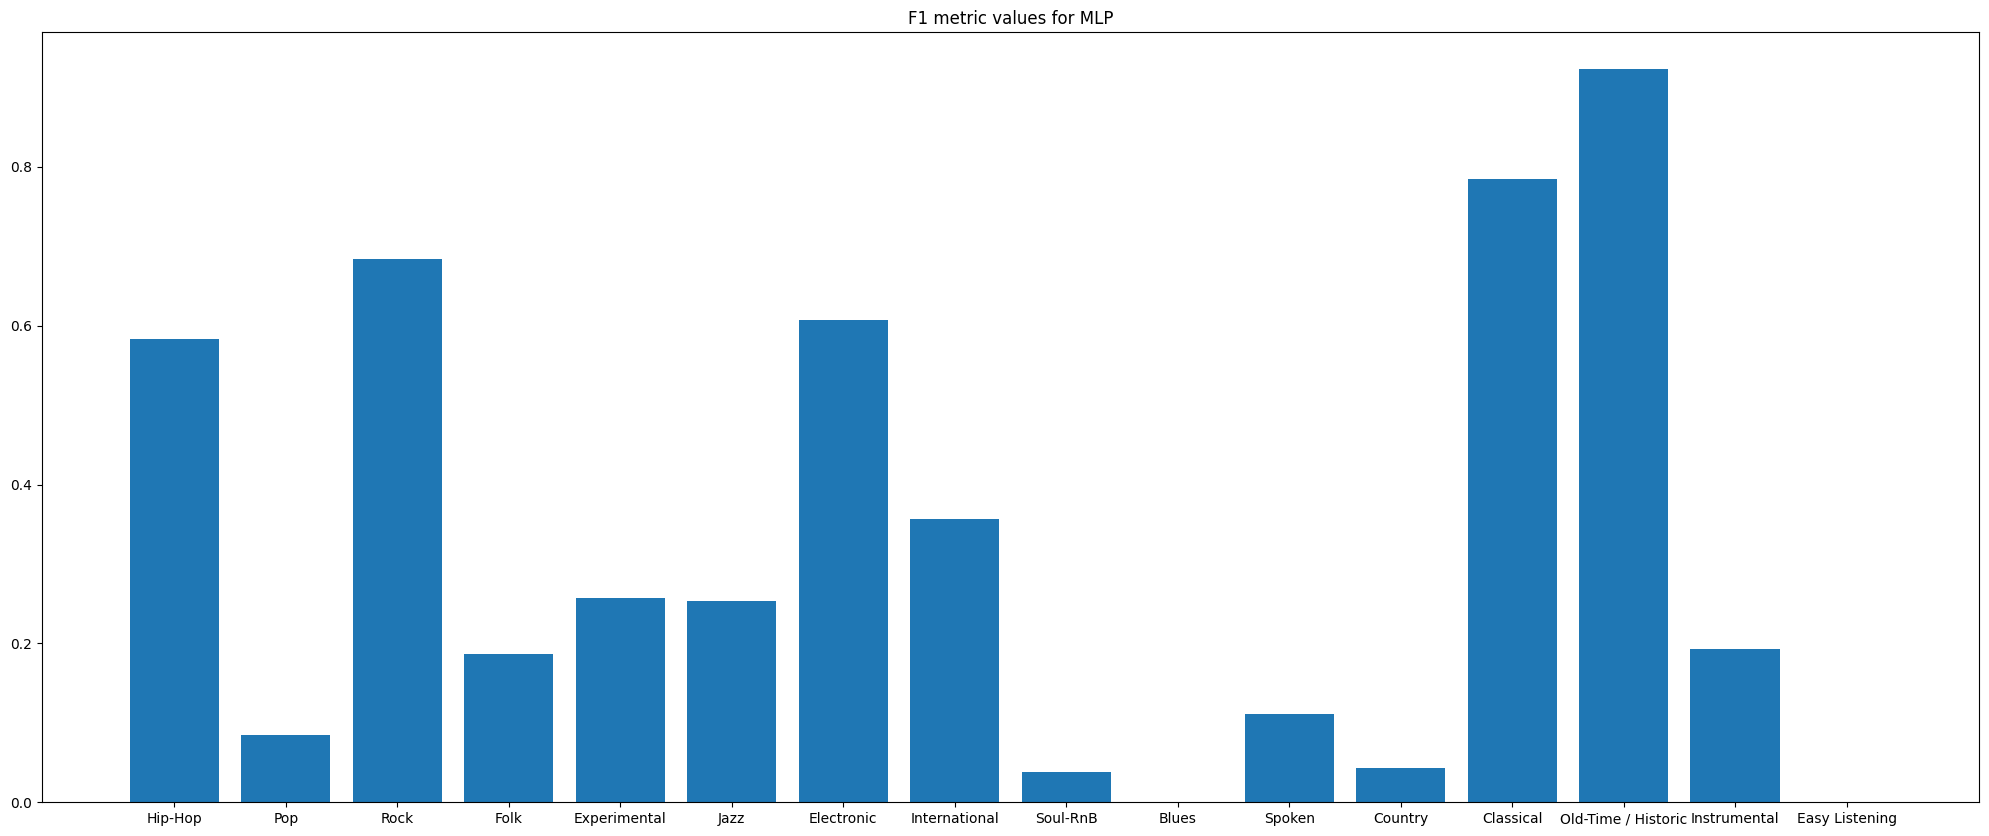

---------------------------------------------------------------------------------------



In [23]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# Gather performance metrics
svm_precision = precision_score(y_test, svm_preds, average=None, labels=labels)
svm_recall = recall_score(y_test, svm_preds, average=None, labels=labels)
svm_f1 = f1_score(y_test, svm_preds, average=None, labels=labels)

knn_precision = precision_score(y_test, knn_predictions, average=None, labels=labels)
knn_recall = recall_score(y_test, knn_predictions, average=None, labels=labels)
knn_f1 = f1_score(y_test, knn_predictions, average=None, labels=labels)

lr_precision = precision_score(y_test, lr_preds, average=None, labels=labels)
lr_recall = recall_score(y_test, lr_preds, average=None, labels=labels)
lr_f1 = f1_score(y_test, lr_preds, average=None, labels=labels)

mlp_precision = precision_score(y_test, mlp_predictions, average=None, labels=labels)
mlp_recall = recall_score(y_test, mlp_predictions, average=None, labels=labels)
mlp_f1 = f1_score(y_test, mlp_predictions, average=None, labels=labels)


print("---------------------------------------------------------------------------------------\n")
print("SVM results:")

#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, svm_preds)))

plt.figure(figsize=(25,10))
plt.bar(labels, svm_precision)
plt.title('Precision metric values for SVM')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, svm_recall)
plt.title('Recall metric values for SVM')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, svm_f1)
plt.title('F1 metric values for SVM')
plt.show()

print("---------------------------------------------------------------------------------------\n")

print("kNN results: ")
#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, knn_predictions)))
plt.figure(figsize=(25,10))
plt.bar(labels, knn_precision)
plt.title('Precision metric values for kNN')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, knn_recall)
plt.title('Recall metric values kNN')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, knn_f1)
plt.title('F1 metric values kNN')
plt.show()

print("---------------------------------------------------------------------------------------\n")

print("Linear Regression results: ")
#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, lr_preds)))
plt.figure(figsize=(25,10))
plt.bar(labels, lr_precision)
plt.title('Precision metric values for LR')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, lr_recall)
plt.title('Recall metric values for LR')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, lr_f1)
plt.title('F1 metric values for LR')
plt.show()

print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
plt.figure(figsize=(25,10))
plt.bar(labels, mlp_precision)
plt.title('Precision metric values for MLP')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, mlp_recall)
plt.title('Recall metric values for MLP')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, mlp_f1)
plt.title('F1 metric values for MLP')
plt.show()

print("---------------------------------------------------------------------------------------\n")

# Conclusions
Conclusioni tipo:
- "miglior" classificatore
- limiti e difficoltà incontrare
- etc...

# Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)